In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

 ## Load data

In [134]:
# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

# metadata
print(predict_students_dropout_and_academic_success.metadata)

# variable information
print(predict_students_dropout_and_academic_success.variables)


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

In [135]:
df = pd.read_csv("data.csv", delimiter=';')
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## Preprocessing

In [136]:
df['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [137]:
def change_target_values(df):
    df['Target'] = df['Target'].apply(lambda x: 'non_Graduate' if x in ['Dropout', 'Enrolled'] else 'Graduate')
    return df

In [138]:
def change_categorical_columns(X):
    for column in X.select_dtypes(include='object').columns:
        X[column] = X[column].map({value: i for i, value in enumerate(X[column].unique())})
    return X

In [139]:
def change_numeric_columns(X):
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
    X[numeric_columns] = (X[numeric_columns] - X[numeric_columns].min()) / (X[numeric_columns].max() - X[numeric_columns].min())
    return X

In [140]:
def preprocess_data(df):
    df = change_target_values(df)
    y = np.where(df['Target'] == 'Graduate', 1, 0)
    X = df.drop(columns=['Target'])
    X = change_categorical_columns(X)
    X = change_numeric_columns(X)
    return X.to_numpy(), y

In [141]:
def split(X, y, test_size=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    m = X.shape[0]
    indices = np.random.permutation(m)
    test_count = int(m * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    return X_train, X_test, y_train, y_test

In [142]:
X = X.to_numpy()
y = np.array(y)
X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.2, seed=42)

## Assignment 1
#### Logistic Regression

In [143]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_fn(y, y_pred):
    m = len(y)
    return -np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9)) / m

def train_model_logistic_regression(X, y, lr=0.01, epochs=1000):
    y = np.array(y, dtype=float)
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    losses = []
    for _ in tqdm(range(epochs), desc="Training", ncols=80):
        z = np.dot(X, w) + b
        y_pred = sigmoid(z)
        loss = loss_fn(y, y_pred)
        dw = np.dot(X.T, (y_pred - y)) / m
        db = np.sum(y_pred - y) / m
        w -= lr * dw
        b -= lr * db
        losses.append(loss)
    return w, b, losses

w, b, losses = train_model_logistic_regression(X_train, y_train, lr=0.01, epochs=1000)

Training: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 11473.48it/s]


#### Prediction & Evaluate

In [144]:
def predict_model_logistic_regression(X, w, b):
    return (sigmoid(np.dot(X, w) + b) >= 0.5).astype(int)
y_pred = predict_model_logistic_regression(X_test, w, b)

print("Predict data: ", y_pred[:10])
print("Real data: ", y_test[:10])

accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Predict data:  [1 1 1 1 0 1 1 0 1 1]
Real data:  [0 1 1 1 0 1 0 0 1 1]
Accuracy: 0.7567873303167421


#### Visualization

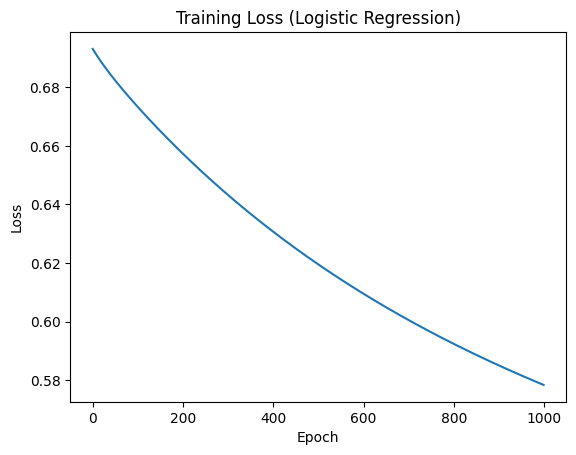

In [145]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Logistic Regression)')
plt.show()

## Assignment 2
#### Softmax Regression

In [146]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y, y_pred):
    m = y.shape[0]
    return -np.sum(y * np.log(y_pred + 1e-9)) / m

In [147]:
def train_model_softmax_regression(X, y, lr=0.01, epochs=1000):
    classes = np.unique(y)
    y_onehot = np.zeros((y.shape[0], len(classes)))
    for i, c in enumerate(classes):
        y_onehot[y == c, i] = 1

    m, n = X.shape
    k = len(classes)
    w = np.zeros((n, k))
    b = np.zeros((1, k))
    losses = []

    for _ in tqdm(range(epochs), desc="Training Softmax", ncols=80):
        z = np.dot(X, w) + b
        y_pred = softmax(z)
        loss = cross_entropy_loss(y_onehot, y_pred)
        dw = np.dot(X.T, (y_pred - y_onehot)) / m
        db = np.sum(y_pred - y_onehot, axis=0, keepdims=True) / m
        w -= lr * dw
        b -= lr * db
        losses.append(loss)

    return w, b, losses,

w, b, losses, = train_model_softmax_regression(X_train, y_train, lr=0.01, epochs=1000)


Training Softmax: 100%|███████████████████| 1000/1000 [00:00<00:00, 3904.09it/s]


#### Prediction & Evaluate

In [148]:
def predict_model_softmax_regression(X, w, b, classes):
    y_pred = softmax(np.dot(X, w) + b)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return classes[y_pred_labels]
y_pred = predict_model_softmax_regression(X_test, w, b, classes)

print("Predict data: ", y_pred[:10])
print("Real data: ", y_test[:10])

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)
print("Accuracy:", accuracy)
acc = accuracy_score(y_test, y_pred)

Predict data:  [1 1 1 0 0 1 1 0 1 1]
Real data:  [0 1 1 1 0 1 0 0 1 1]
Accuracy: 0.7567873303167421


#### Visualization

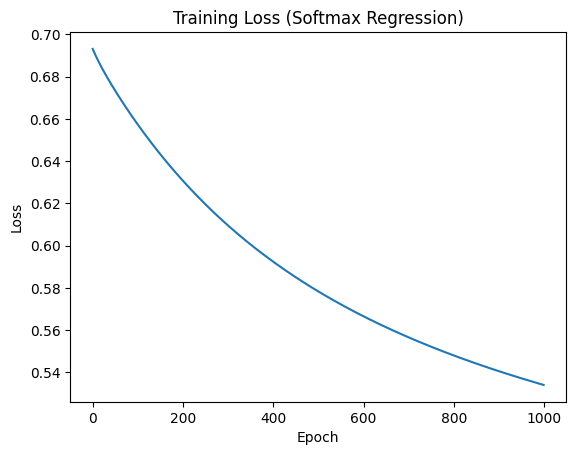

In [149]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Softmax Regression)')
plt.show()

## Assignment 3

In [150]:
# Logistic Regression (binary)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

# Softmax Regression (multiclass)
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
softmax_reg.fit(X_train, y_train)
y_pred_softmax = softmax_reg.predict(X_test)

print("Softmax Regression Accuracy:", accuracy_score(y_test, y_pred_softmax))

Logistic Regression Accuracy: 0.830316742081448
Softmax Regression Accuracy: 0.830316742081448


C:\Users\PC\PycharmProjects\lab02_ds102\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
